# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sentence_transformers import SentenceTransformer
from top2vec import Top2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import umap
import hdbscan

pd.set_option('display.max_columns', None)

# Подготовим статьи в пригодный формат

In [2]:
arxiv = pd.read_csv('../data/prepared_arxiv.csv', usecols=['title', 'abstract', 'categories'])

# В связи с ограниченными вычислительными мощностями, решили взять случайный семпл из 20 тысяч статей
arxiv = arxiv.sample(20_000)

print(arxiv.shape)
arxiv.head(3)

(20000, 3)


title  \
1317861  Planetesimal formation during protoplanetary d...   
1456815                            Asynchronous Scattering   
742510   Further results on the observability analysis ...   

                                                categories  \
1317861                                    Astrophysics.EP   
1456815  Multiagent Systems Distributed, Parallel, and ...   
742510                                            Robotics   

                                                  abstract  
1317861    Models of dust coagulation and subsequent pl...  
1456815    In this paper, we consider the problem of sc...  
742510     The issue of single range based observabilit...

In [3]:
documents = (arxiv['title'].str.replace('\n', '').str.strip() + '. ' + arxiv['abstract'].str.replace('\n', ' ').str.strip()).values.tolist()

documents[:2]

['Planetesimal formation during protoplanetary disk buildup. Models of dust coagulation and subsequent planetesimal formation are usually computed on the backdrop of an already fully formed protoplanetary disk model. At the same time, observational studies suggest that planetesimal formation should start early, possibly even before the protoplanetary disk is fully formed. In this paper, we investigate under which conditions planetesimals already form during the disk buildup stage, in which gas and dust fall onto the disk from its parent molecular cloud. We couple our earlier planetesimal formation model at the water snow line to a simple model of disk formation and evolution. We find that under most conditions planetesimals only form after the buildup stage when the disk becomes less massive and less hot. However, there are parameters for which planetesimals already form during the disk buildup. This occurs when the viscosity driving the disk evolution is intermediate ($\\alpha_v \\sim

# Натренируем модель

In [4]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(documents, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [15:38<00:00,  1.50s/it]


In [5]:
# размерность вектора для одной статьи
len(embeddings[0])

768

# Сохраним эмбеддинги

In [13]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv('../data/distilbert_embeddings.tsv', sep='\t', index=False, header=None)

In [14]:
pd.DataFrame(arxiv['categories']).to_csv('../data/labels.tsv', sep='\t', index=False, header=None)

# Визуализируем кластеризацию статей в двумерном пространстве

In [7]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=128, 
                            metric='cosine').fit_transform(embeddings)

In [8]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean').fit(umap_embeddings) # cluster_selection_method='eom'

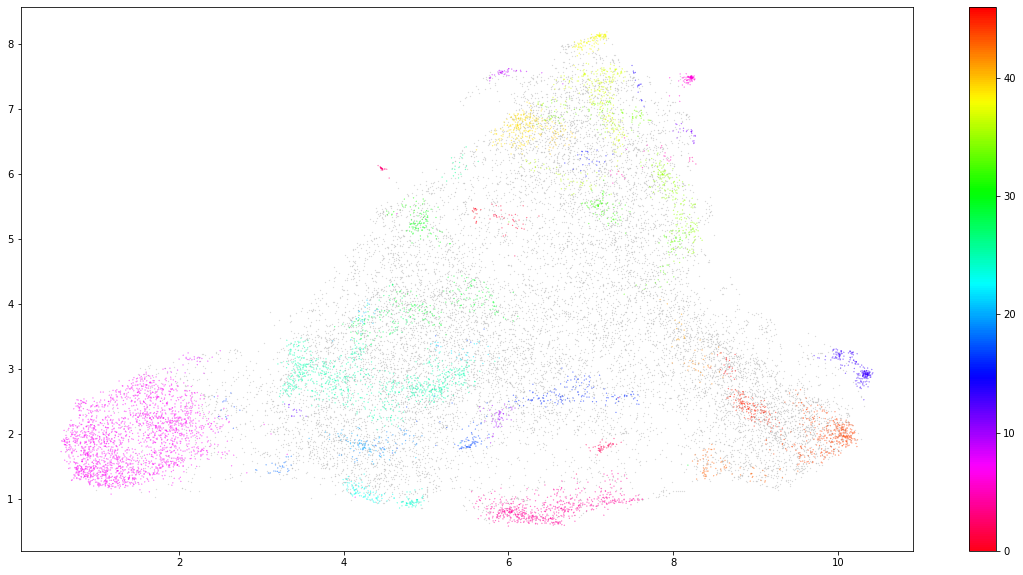

In [9]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

# Возьмем два разных года

In [17]:
arxiv = pd.read_csv('../data/prepared_arxiv.csv', usecols=['title', 'abstract', 'categories', 'publication_year'])

year_2007 = arxiv[arxiv['publication_year'] == 2007].sample(20_000).drop(columns=['publication_year'])
year_2017 = arxiv[arxiv['publication_year'] == 2017].sample(20_000).drop(columns=['publication_year'])

print(year_2007.shape)
year_2007.head()

(20000, 3)


title  \
235162  Predictions from non trivial Quark-Lepton comp...   
54538          The Formation and Evolution of S0 Galaxies   
586110  Doppler-free, Multi-wavelength Acousto-optic d...   
54619   The mass distribution of dwarf spheroidal gala...   
137681               Quantum heat engines and information   

                                 categories  \
235162  High Energy Physics - Phenomenology   
54538                          Astrophysics   
586110                      Quantum Physics   
54619                          Astrophysics   
137681                      Quantum Physics   

                                                 abstract  
235162    The complementarity between the quark and le...  
54538     This thesis studies the origin of local S0 g...  
586110    We demonstrate a dual wavelength acousto-opt...  
54619     We model three dSph galaxies, Draco, Ursa Mi...  
137681    Recently, Zhang {\em et al.} [PRA, {\bf 75},...

In [18]:
documents_2007 = (year_2007['title'].str.replace('\n', '').str.strip() + '. ' + year_2007['abstract'].str.replace('\n', ' ').str.strip()).values.tolist()
documents_2017 = (year_2017['title'].str.replace('\n', '').str.strip() + '. ' + year_2017['abstract'].str.replace('\n', ' ').str.strip()).values.tolist()

documents_2007[:2]

['Predictions from non trivial Quark-Lepton complementarity. The complementarity between the quark and lepton mixing matrices is shown to provide robust predictions. We obtain these predictions by first showing that the matrix V_M, product of the quark (CKM) and lepton (PMNS) mixing matrices, may have a zero (1,3) entry which is favored by experimental data.   We obtain that any theoretical model with a vanishing (1,3) entry of V_M that is in agreement with quark data, solar, and atmospheric mixing angle leads to $\\theta_{13}^{PMNS}=(9{^{+1}_{-2}})^\\circ$. This value is consistent with the present 90% CL experimental upper limit. We also investigate the prediction on the lepton phases. We show that the actual evidence, under the only assumption that the correlation matrix V_M product of CKM and PMNS has a zero in the entry (1,3), gives us a prediction for the three CP-violating invariants J, S_1, and S_2. A better determination of the lepton mixing angles will give stronger predictio

In [19]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

embeddings_2007 = model.encode(documents_2007, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [15:10<00:00,  1.46s/it]


In [20]:
embeddings_2017 = model.encode(documents_2017, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [15:26<00:00,  1.48s/it]


In [21]:
embeddings_df_2007 = pd.DataFrame(embeddings_2007)
embeddings_df_2007.to_csv('../data/distilbert_embeddings_2007.tsv', sep='\t', index=False, header=None)

pd.DataFrame(year_2007['categories']).to_csv('../data/labels_2007.tsv', sep='\t', index=False, header=None)

In [22]:
embeddings_df_2017 = pd.DataFrame(embeddings_2017)
embeddings_df_2017.to_csv('../data/distilbert_embeddings_2017.tsv', sep='\t', index=False, header=None)

pd.DataFrame(year_2017['categories']).to_csv('../data/labels_2017.tsv', sep='\t', index=False, header=None)

In [39]:
umap_embeddings_2007 = umap.UMAP(n_neighbors=15, 
                            n_components=128, 
                            metric='cosine').fit_transform(embeddings_2007)

cluster_2007 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_embeddings_2007) 

In [24]:
umap_embeddings_2017 = umap.UMAP(n_neighbors=15, 
                            n_components=128, 
                            metric='cosine').fit_transform(embeddings_2017)

cluster_2017 = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean').fit(umap_embeddings_2017) 

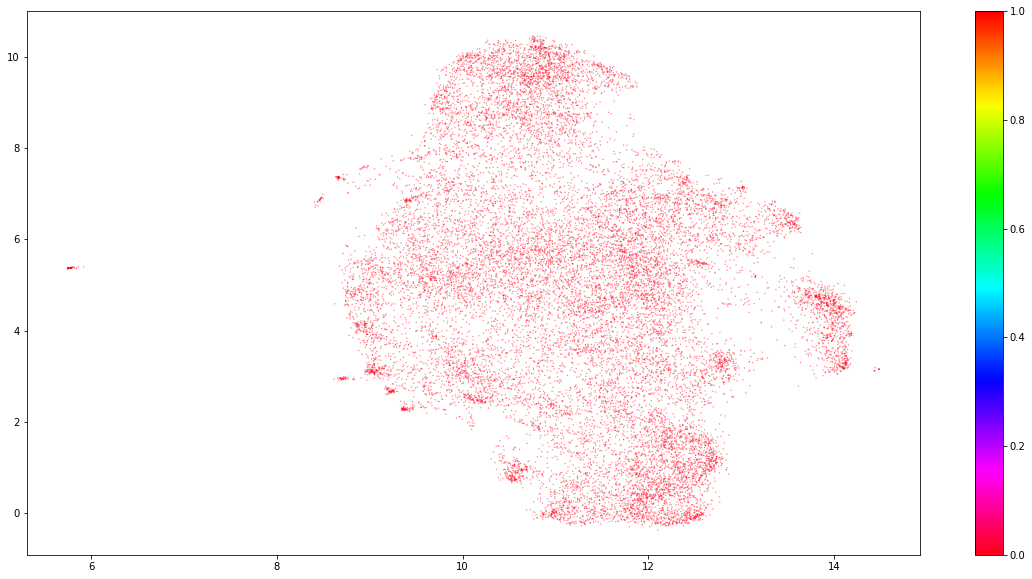

In [40]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_2007)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_2007.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

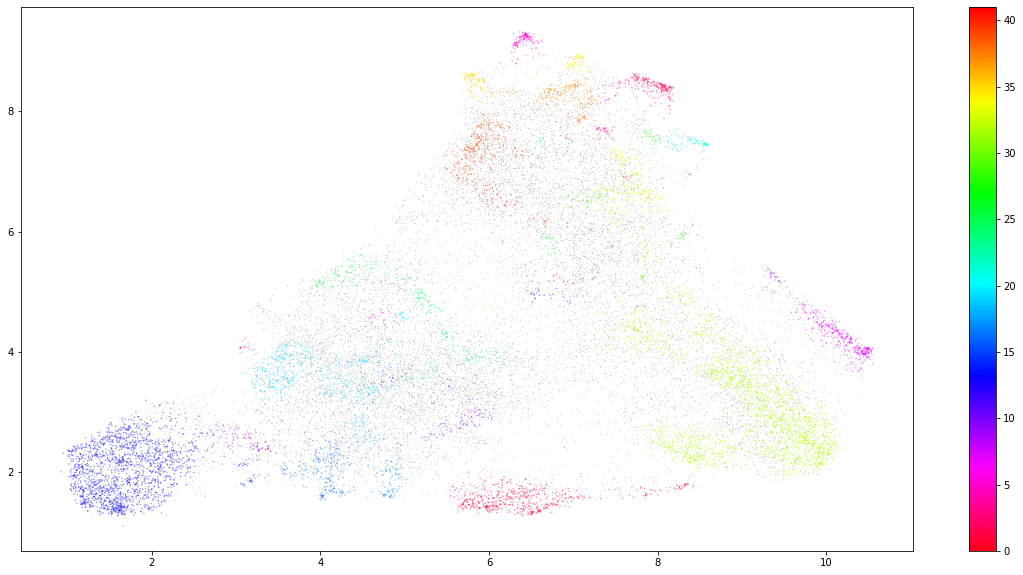

In [26]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_2017)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_2017.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()